# Sentiments Index

## Preparation of Excel File

In [118]:
# combining date from texts_cleaned.xlsx with sentiments.xlsx
import pandas as pd
import json

# reading sentiments.xlsx as sentiments dataframe
excel_file = 'sentiments.xlsx'
sheet_name = '2020 - 2024' ## change the sheet name accordingly 
sentiments = pd.read_excel(excel_file, sheet_name=sheet_name)

# extracting custom id and user content from jsonl
def extract_custom_id_and_user_content(jsonl_file_path):
    results = []

    with open(jsonl_file_path, 'r') as file:
        for line in file:
            data = json.loads(line.strip())
            custom_id = data.get('custom_id')
            messages = data.get('body', {}).get('messages', [])
            user_content = None
            for message in messages:
                if message.get('role') == 'user':
                    user_content = message.get('content')
                    break

            if custom_id and user_content:
                results.append({
                    'custom_id': custom_id,
                    'user_content': user_content
                })

    return results

jsonl_file_path = './chatgpt/jsonl/2020_2024(1).jsonl' ## use the base file for the chatgpt batch api
extracted_data = extract_custom_id_and_user_content(jsonl_file_path)

jsonl = pd.DataFrame(extracted_data)

# merging sentiments with texts
merged_df = pd.merge(jsonl, sentiments, on='custom_id')

# reading texts_cleaned.xlsx as texts_cleaned dataframe
excel_file = 'texts_cleaned.xlsx'
texts_cleaned = pd.read_excel(excel_file, sheet_name=sheet_name)

# merging texts_cleaned with merged_df
final_df = pd.merge(texts_cleaned, merged_df, right_on='user_content', left_on='Text')

# drop columns user_content and custom_id
final_df = final_df.drop(columns=['user_content', 'custom_id'])

# final_df.to_excel('sentiments_cleaned.xlsx', sheet_name=sheet_name, index=False)
with pd.ExcelWriter('sentiments_cleaned.xlsx', engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    final_df.to_excel(writer, sheet_name=sheet_name, index=False)



## Data Analysis

### Boolean

In [139]:
import pandas as pd

def compare_columns(df):
    # mapping categorical values to numerical values
    mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
    
    # apply the mapping to both columns
    df['boolean_x'] = df['categorical_x'].map(mapping)
    df['boolean_y'] = df['categorical_y'].map(mapping)
    
    # calculate the absolute difference
    df['boolean_difference'] = (df['boolean_x'] - df['boolean_y']).abs()
     
    return df

excel_file = 'sentiments_cleaned.xlsx'
sheet_name = '2020 - 2024' ## change this accordingly

df = pd.read_excel(excel_file, sheet_name=sheet_name)
df = compare_columns(df)

# df.to_excel('market_sentiments.xlsx', sheet_name=sheet_name, index=False)
with pd.ExcelWriter('market_sentiments.xlsx', engine="openpyxl", mode="a", if_sheet_exists="replace") as writer:
    df.to_excel(writer, sheet_name=sheet_name, index=False)

#### Graph

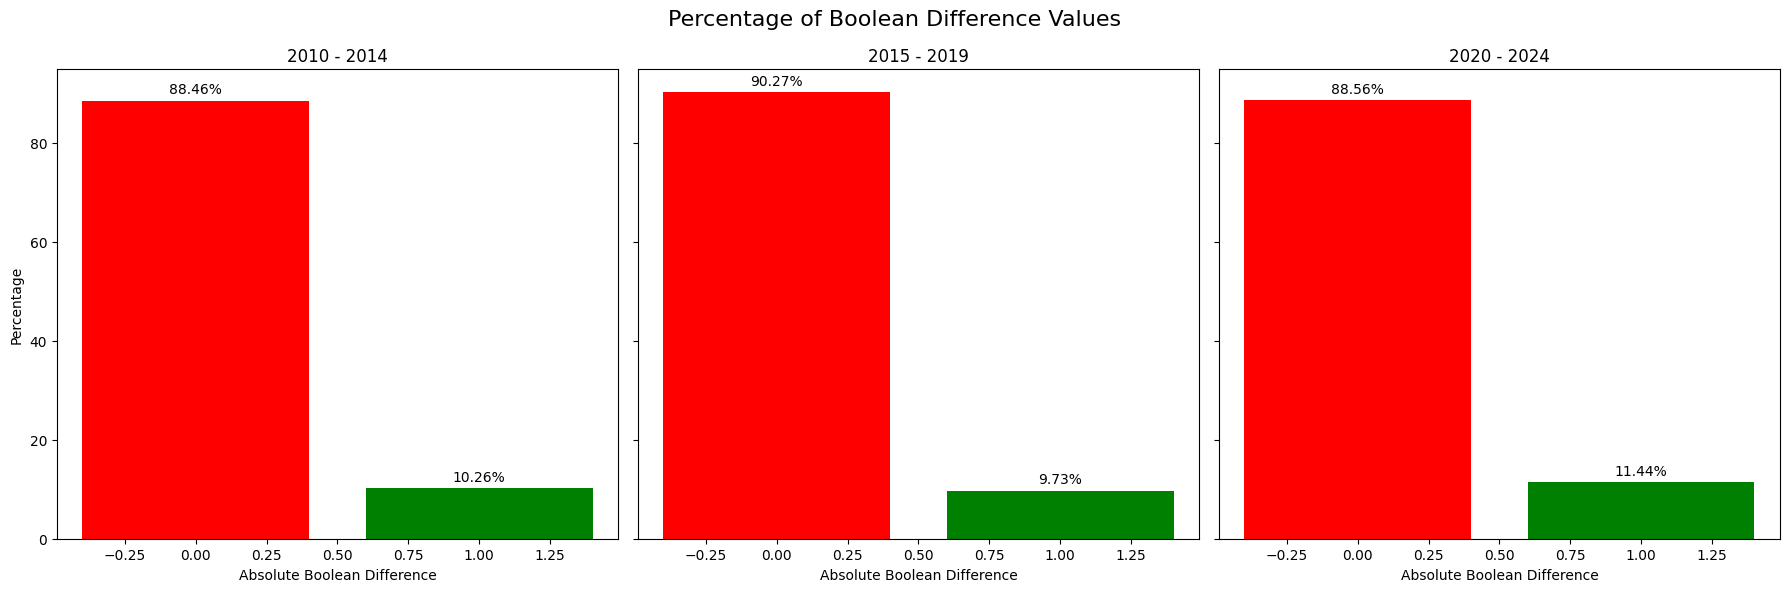

In [120]:
## i did this graph but i didn't know how to utilise this, it just shows whether both categorical prompts resulted in the same output by ChatGPT
## i think this shows that ChatGPT in general outputs consistent result, which shows that the numerical values would be more or less reliable in a sense
import pandas as pd
import matplotlib.pyplot as plt

# function to calculate the percentage of boolean_difference values
def calculate_percentage(df):
    total_count = df['boolean_difference'].value_counts()
    percentage = (total_count / len(df)) * 100
    return percentage.sort_index()

# read the Excel file
file_path = 'market_sentiments.xlsx'
sheets = ['2010 - 2014', '2015 - 2019', '2020 - 2024']

# read the data from each sheet
dataframes = {sheet: pd.read_excel(file_path, sheet_name=sheet) for sheet in sheets}

# calculate percentages for each dataframe
percentages = {sheet: calculate_percentage(df) for sheet, df in dataframes.items()}

# plotting the bar charts
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

colors = ['red', 'green', 'blue']

for ax, (sheet, percentage) in zip(axes, percentages.items()):
    bars = ax.bar(percentage.index, percentage.values, color=colors)
    
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords='offset points',
                    ha='center', va='bottom')

    ax.set_xlabel('Absolute Boolean Difference')
    ax.set_ylabel('Percentage' if ax == axes[0] else '')
    ax.set_title(f'{sheet}')

# adjust layout and show the plot
fig.suptitle('Percentage of Boolean Difference Values', fontsize=16)
plt.tight_layout()
plt.show()


### Numerical

In [141]:
import pandas as pd

excel_file_path = 'market_sentiments.xlsx'
sheets = pd.read_excel(excel_file_path, sheet_name=None)

# function to calculate numerical difference
def calculate_numerical_difference(df):
    df['numerical_difference'] = (
        abs(df['numerical_x'] - df['numerical_y']) +
        abs(df['numerical_y'] - df['numerical_z']) +
        abs(df['numerical_x'] - df['numerical_z'])
    ) / 3
    return df

# apply the function to each sheet
for sheet_name, df in sheets.items():
    sheets[sheet_name] = calculate_numerical_difference(df)

# save the modified dataframes back to the Excel file
with pd.ExcelWriter(excel_file_path, engine='openpyxl') as writer:
    for sheet_name, df in sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)


#### Graph

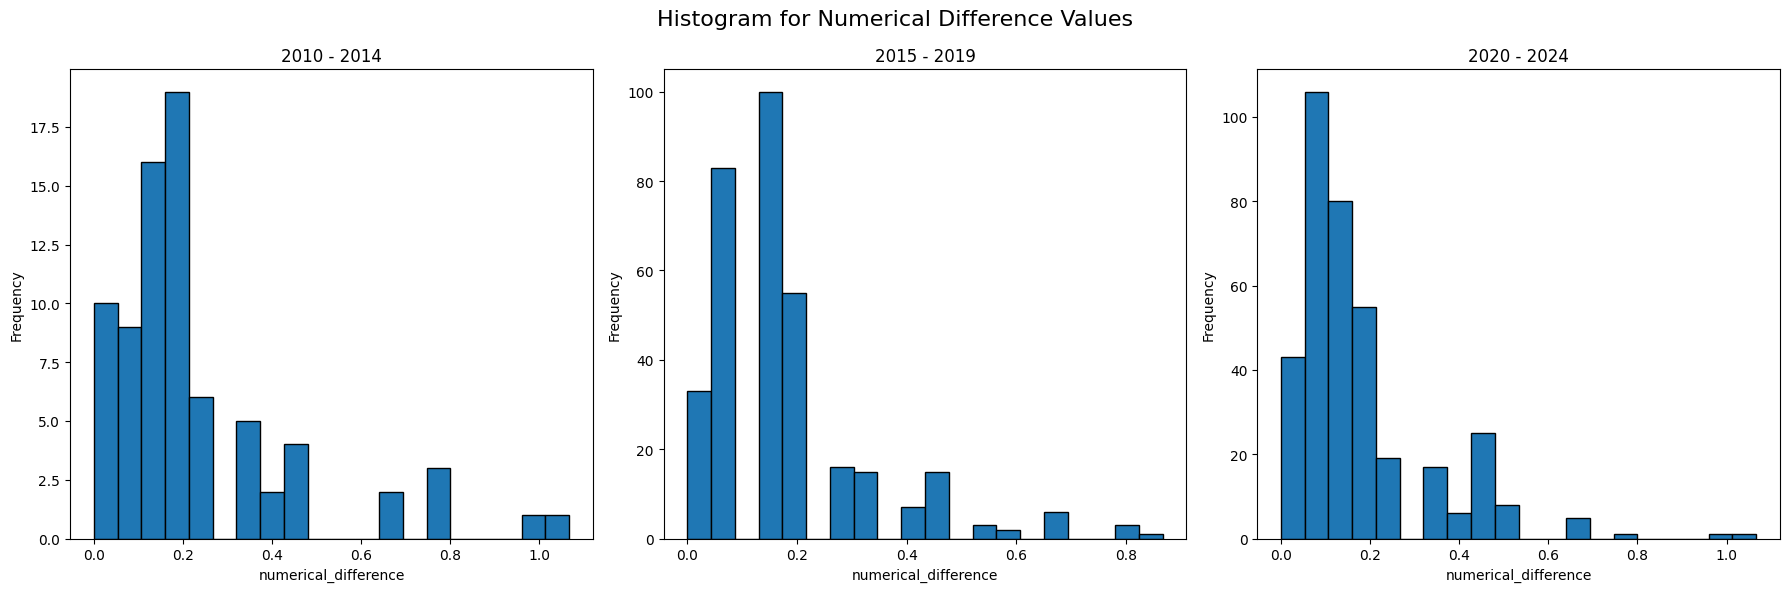

In [122]:
file_path = 'market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)
column_name = 'numerical_difference'

# initialize a list to store the data from each sheet
data_list = []

# loop through each sheet name, read the data, and extract the specific column
for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    data_list.append(df[column_name])

# create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# loop through the data list and corresponding axes to plot histograms
for i, data in enumerate(data_list):
    axes[i].hist(data, bins=20, edgecolor='black')
    axes[i].set_title(f'{excel_data.sheet_names[i]}')
    axes[i].set_xlabel(column_name)
    axes[i].set_ylabel('Frequency')

# adjust layout and display the plots
fig.suptitle('Histogram for Numerical Difference Values', fontsize=16)
plt.tight_layout()
plt.show()


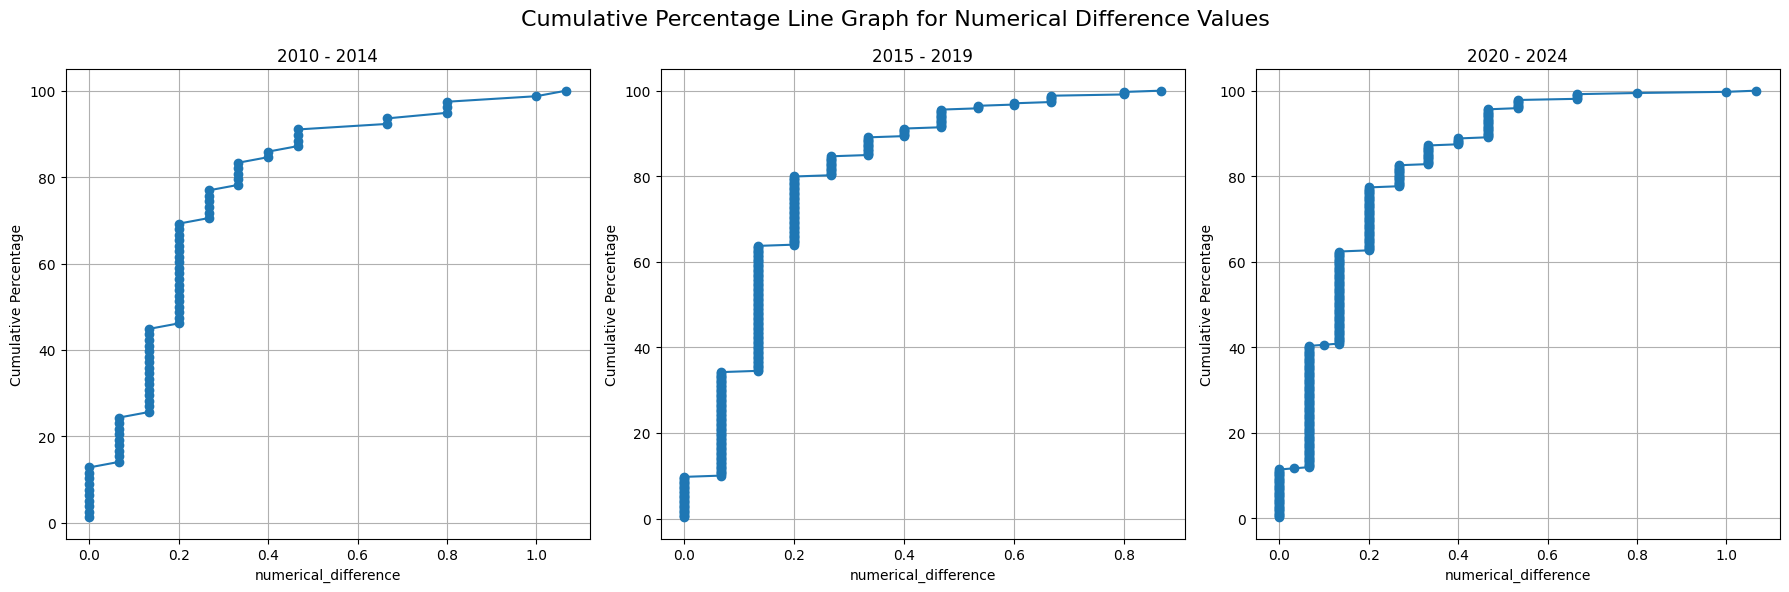

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)
column_name = 'numerical_difference'

# initialize a list to store the data from each sheet
data_list = []

# loop through each sheet name, read the data, and extract the specific column
for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    data_list.append(df[column_name])

# create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# loop through the data list and corresponding axes to plot cumulative percentage line graphs
for i, data in enumerate(data_list):
    # Calculate the cumulative frequency
    sorted_data = np.sort(data)
    cumulative_frequency = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

    # Plot the line graph
    axes[i].plot(sorted_data, cumulative_frequency, marker='o')
    axes[i].set_title(f'{excel_data.sheet_names[i]}')
    axes[i].set_xlabel(column_name)
    axes[i].set_ylabel('Cumulative Percentage')
    axes[i].grid(True)

# adjust layout and display the plots
fig.suptitle('Cumulative Percentage Line Graph for Numerical Difference Values', fontsize=16)
plt.tight_layout()
plt.show()

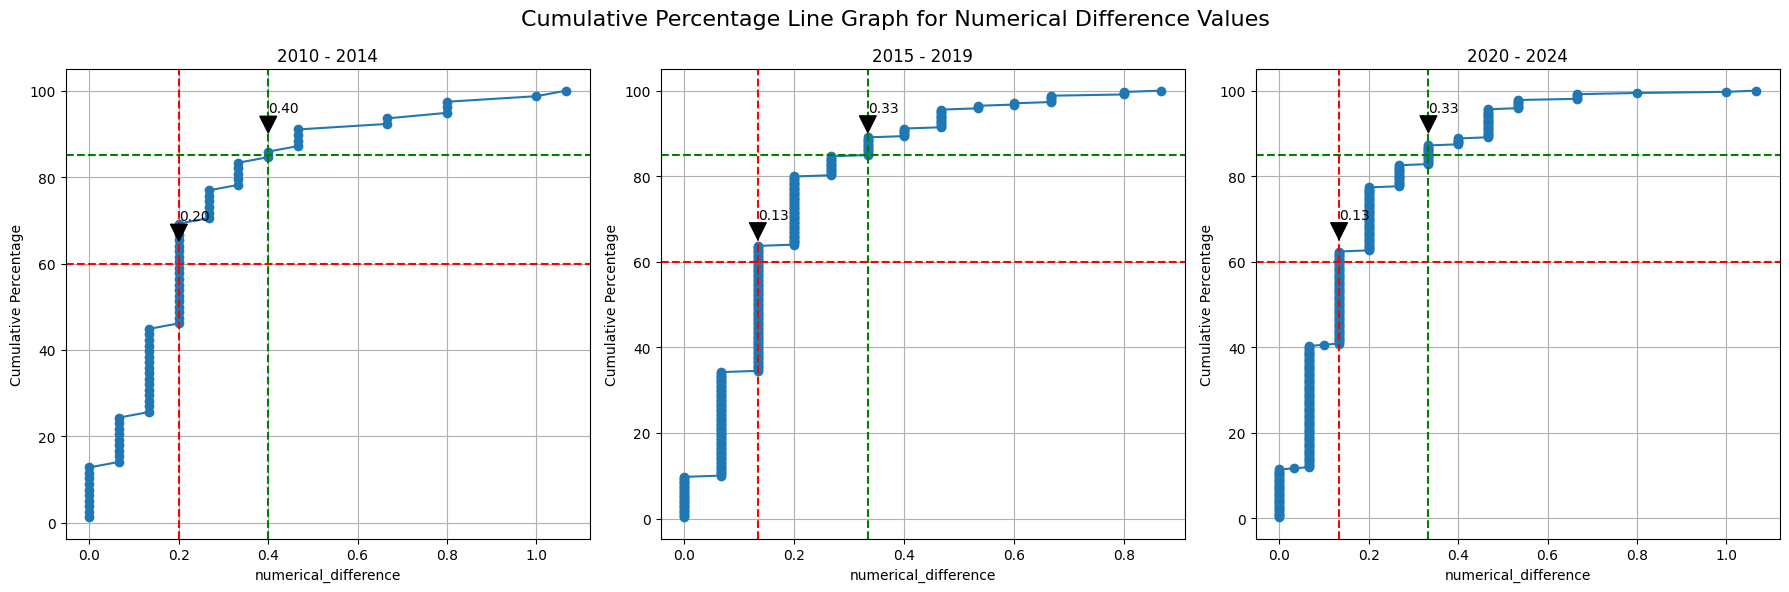

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = 'market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)
column_name = 'numerical_difference'

# initialize a list to store the data from each sheet
data_list = []

# loop through each sheet name, read the data, and extract the specific column
for sheet in excel_data.sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    data_list.append(df[column_name])

# create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# loop through the data list and corresponding axes to plot cumulative percentage line graphs
for i, data in enumerate(data_list):
    # calculate the cumulative frequency
    sorted_data = np.sort(data)
    cumulative_frequency = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

    # determine the x value where cumulative frequency hits 60%
    x_value_at_60_percent = np.interp(60, cumulative_frequency, sorted_data)
    x_value_at_85_percent = np.interp(85, cumulative_frequency, sorted_data)

    # plot the line graph
    axes[i].plot(sorted_data, cumulative_frequency, marker='o')
    axes[i].set_title(f'{excel_data.sheet_names[i]}')
    axes[i].set_xlabel(column_name)
    axes[i].set_ylabel('Cumulative Percentage')
    axes[i].grid(True)
    
    # plot horizontal line at 60% cumulative frequency
    axes[i].axhline(y=60, color='r', linestyle='--')
    axes[i].axhline(y=85, color='g', linestyle='--')
    
    # plot vertical line at x value where cumulative frequency hits 60%
    axes[i].axvline(x=x_value_at_60_percent, color='r', linestyle='--')
    axes[i].axvline(x=x_value_at_85_percent, color='g', linestyle='--')
    
    # annotate the point where cumulative frequency hits 60%
    axes[i].annotate(f'{x_value_at_60_percent:.2f}', xy=(x_value_at_60_percent, 65), xytext=(x_value_at_60_percent, 70),
                    arrowprops=dict(facecolor='black', shrink=0.05))
    axes[i].annotate(f'{x_value_at_85_percent:.2f}', xy=(x_value_at_85_percent, 90), xytext=(x_value_at_85_percent, 95),
                    arrowprops=dict(facecolor='black', shrink=0.05))

# adjust layout and display the plots
fig.suptitle('Cumulative Percentage Line Graph for Numerical Difference Values', fontsize=16)
plt.tight_layout()
plt.show()


## Market Sentiments

In [142]:
import pandas as pd

# load the Excel file
file_path = 'market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)

# read each sheet into a dictionary of DataFrames
sheets = {sheet_name: excel_data.parse(sheet_name) for sheet_name in excel_data.sheet_names}

# function to process each DataFrame
def process_sheet(df):
    # calculate the 60th percentile for numerical_difference
    percentile_60 = df['numerical_difference'].quantile(0.6)
    
    # filter rows where numerical_difference is below the 60th percentile
    filtered_df = df[df['numerical_difference'] <= percentile_60]
    
    # calculate the average of numerical_x, numerical_y, and numerical_z
    average_values = filtered_df[['numerical_x', 'numerical_y', 'numerical_z']].mean(axis=1)
    
    # assign these average values to a new column 'sentiment' in the original DataFrame
    df['sentiment'] = average_values.reindex(df.index, fill_value=None)
    
    return df

# process each sheet
processed_sheets = {sheet_name: process_sheet(sheet) for sheet_name, sheet in sheets.items()}

with pd.ExcelWriter('processed_market_sentiments.xlsx') as writer:
    for sheet_name, sheet in processed_sheets.items():
        sheet.to_excel(writer, sheet_name=sheet_name, index=False)


In [143]:
import pandas as pd

# load the existing Excel file with the 'sentiments' column
file_path = 'processed_market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)

# read each sheet into a dictionary of DataFrames
sheets = {sheet_name: excel_data.parse(sheet_name) for sheet_name in excel_data.sheet_names}

# function to process each DataFrame for specific filtering and sentiment calculation
def process_sheet(df):
    # calculate the 60th and 85th percentiles for numerical_difference
    percentile_60 = df['numerical_difference'].quantile(0.6)
    percentile_85 = df['numerical_difference'].quantile(0.85)
    
    # filter rows where numerical_difference is above the 60th percentile and below or equal to the 85th percentile
    filtered_df = df[(df['numerical_difference'] > percentile_60) & (df['numerical_difference'] <= percentile_85)].copy()
    
    # function to find the average of the two closest numbers among x, y, and z
    def find_closest_average(row):
        nums = [row['numerical_x'], row['numerical_y'], row['numerical_z']]
        nums.sort()
        closest_avg = (nums[1] + nums[0]) / 2 if abs(nums[1] - nums[0]) <= abs(nums[2] - nums[1]) else (nums[2] + nums[1]) / 2
        return closest_avg
    
    # apply the function to each row in the filtered DataFrame
    filtered_df['sentiment'] = filtered_df.apply(find_closest_average, axis=1)
    
    # update the original DataFrame's 'sentiments' column with the calculated values, preserving existing values
    df.loc[filtered_df.index, 'sentiment'] = filtered_df['sentiment']
    
    return df

# process each sheet
processed_sheets = {sheet_name: process_sheet(sheet) for sheet_name, sheet in sheets.items()}

# save the updated data back to the existing Excel file
with pd.ExcelWriter(file_path) as writer:
    for sheet_name, sheet in processed_sheets.items():
        sheet.to_excel(writer, sheet_name=sheet_name, index=False)


In [144]:
import pandas as pd

# load the existing Excel file with the 'sentiments' column
file_path = 'processed_market_sentiments.xlsx'
excel_data = pd.ExcelFile(file_path)

# read each sheet into a dictionary of DataFrames
sheets = {sheet_name: excel_data.parse(sheet_name) for sheet_name in excel_data.sheet_names}

# function to process each DataFrame for specific filtering and sentiment calculation
def process_sheet(df):
    # calculate the 85th percentile for numerical_difference
    percentile_85 = df['numerical_difference'].quantile(0.85)
    
    # filter rows where numerical_difference is above the 85th percentile
    filtered_df = df[df['numerical_difference'] > percentile_85].copy()
    
    # calculate the average of numerical_x, numerical_y, numerical_z, boolean_x, and boolean_y
    filtered_df['sentiment'] = filtered_df[['numerical_x', 'numerical_y', 'numerical_z', 'boolean_x', 'boolean_y']].mean(axis=1)
    
    # update the original DataFrame's 'sentiments' column with the calculated values, preserving existing values
    df.loc[filtered_df.index, 'sentiment'] = filtered_df['sentiment']
    
    return df

# process each sheet
processed_sheets = {sheet_name: process_sheet(sheet) for sheet_name, sheet in sheets.items()}

# save the updated data back to the existing Excel file
with pd.ExcelWriter(file_path) as writer:
    for sheet_name, sheet in processed_sheets.items():
        sheet.to_excel(writer, sheet_name=sheet_name, index=False)


## Final Market Sentiments

In [151]:
## essentially merging all the values, keeping the date and sentiment into one single dataframe and saved into a new excel
file_path = 'processed_market_sentiments.xlsx'

processed_dfs = []
sheet_names = pd.ExcelFile(file_path).sheet_names

for sheet in sheet_names:
    # read the sheet into a DataFrame
    df = pd.read_excel(file_path, sheet_name=sheet)
    
    # select the 'Date' and 'sentiment' columns
    df = df[['Date', 'sentiment']]
    
    # rename the 'sentiment' column to 'Sentiments'
    df.rename(columns={'sentiment': 'Sentiments'}, inplace=True)
    
    # slicing the 'Date' column
    df['Date'] = df['Date'].str[:10]
    
    # ensure the 'Sentiments' column is numerical
    df['Sentiments'] = pd.to_numeric(df['Sentiments'], errors='coerce')
    
    # append the processed DataFrame to the list
    processed_dfs.append(df)

# concatenate all processed DataFrames
final_df = pd.concat(processed_dfs, ignore_index=True)

# display the processed DataFrame
print(final_df.head())

# save the processed DataFrame to a new Excel file
final_df.to_excel('final_market_sentiments.xlsx', sheet_name='master',index=False)


         Date  Sentiments
0  2010-05-21    0.800000
1  2013-11-25    0.150000
2  2013-10-14    0.300000
3  2014-03-01    0.150000
4  2014-03-04   -0.633333


### Monthly

In [244]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
df = pd.read_excel(file_path, sheet_name='master')

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Month'] = df['Date'].dt.to_period('M')
grouped = df.groupby('Month').agg(
    Average_Sentiment=('Sentiments', 'mean'),
    Frequency=('Sentiments', 'count')
).reset_index()

with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    grouped.to_excel(writer, sheet_name='monthly sentiments', index=False)


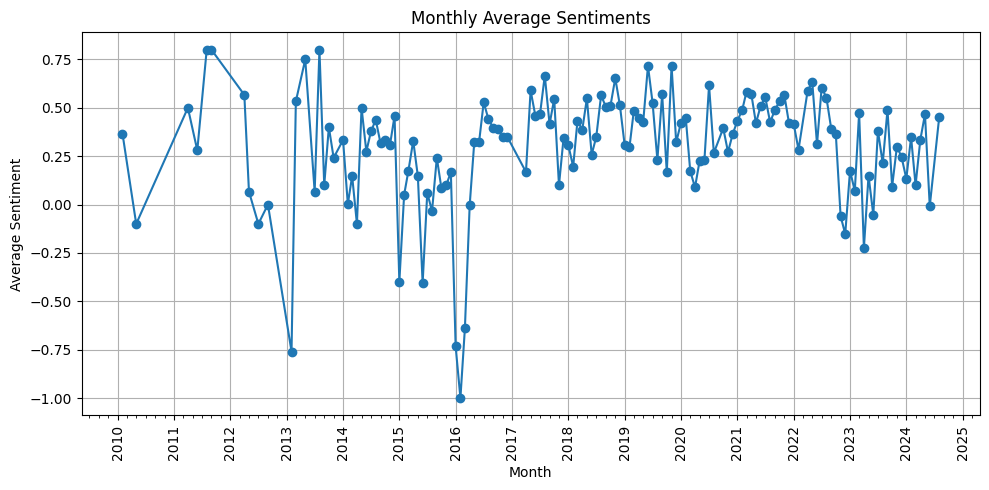

In [245]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='monthly sentiments')

monthly_sentiments['Month'] = pd.to_datetime(monthly_sentiments['Month'])

plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiments['Month'], monthly_sentiments['Average_Sentiment'], marker='o')
plt.title('Monthly Average Sentiments')
plt.xlabel('Month')
plt.ylabel('Average Sentiment')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1, 3, 5, 7, 9, 11]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Month on Month

In [246]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='monthly sentiments')

monthly_sentiments['Percentage Change'] = monthly_sentiments['Average_Sentiment'].pct_change()

with pd.ExcelWriter('final_market_sentiments.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    monthly_sentiments.to_excel(writer, sheet_name='monthly sentiments', index=False)


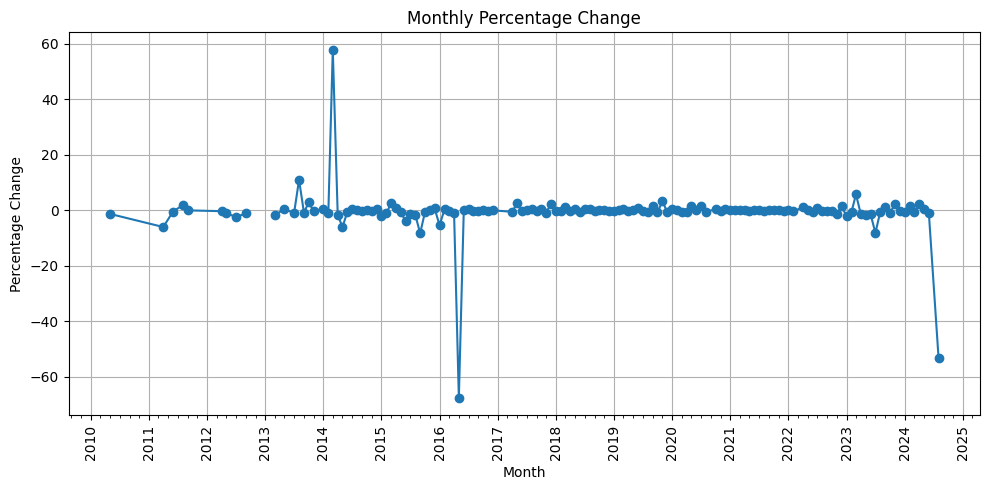

In [247]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='monthly sentiments')

monthly_sentiments['Month'] = pd.to_datetime(monthly_sentiments['Month'])

plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiments['Month'], monthly_sentiments['Percentage Change'], marker='o')
plt.title('Monthly Percentage Change')
plt.xlabel('Month')
plt.ylabel('Percentage Change')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1, 3, 5, 7, 9, 11]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


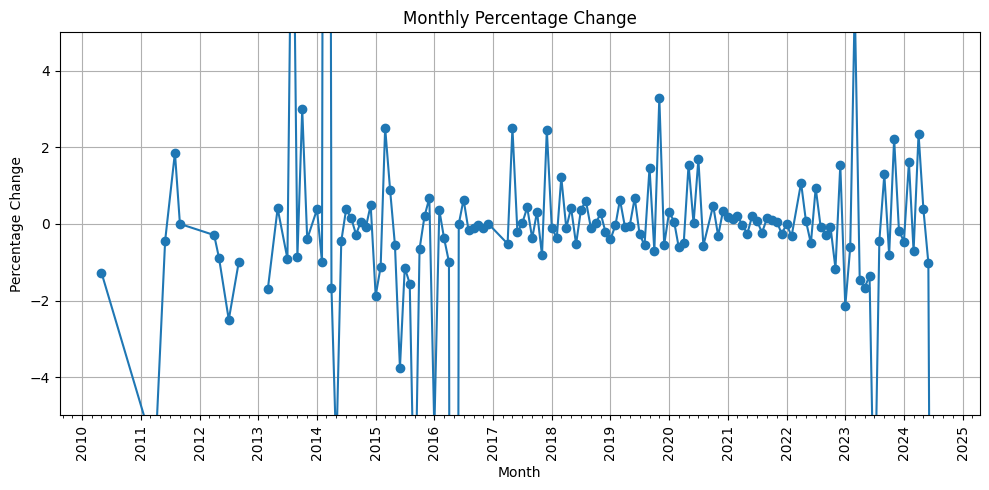

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='monthly sentiments')

monthly_sentiments['Month'] = pd.to_datetime(monthly_sentiments['Month'])

plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiments['Month'], monthly_sentiments['Percentage Change'], marker='o')
plt.title('Monthly Percentage Change')
plt.xlabel('Month')
plt.ylabel('Percentage Change')

plt.ylim(-5, 5)

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1, 3, 5, 7, 9, 11]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


### Quarterly

In [265]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
df = pd.read_excel(file_path, sheet_name='master')

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Quarter'] = df['Date'].dt.to_period('Q')

grouped = df.groupby('Quarter').agg(
    Average_Sentiment=('Sentiments', 'mean'),
    Frequency=('Sentiments', 'count')
).reset_index()

with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    grouped.to_excel(writer, sheet_name='quarterly sentiments', index=False)


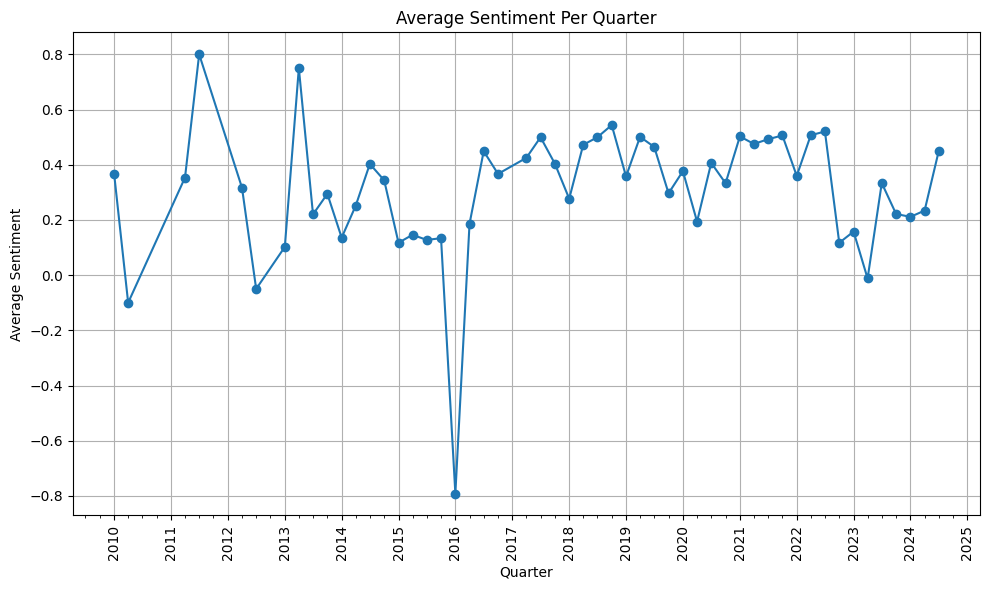

In [250]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# read the Excel file
file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='quarterly sentiments')

# extract year and quarter and create a datetime-like object
monthly_sentiments['Year'] = monthly_sentiments['Quarter'].str[:4].astype(int)
monthly_sentiments['Quarter_Num'] = monthly_sentiments['Quarter'].str[-1].astype(int)
monthly_sentiments['Date'] = pd.to_datetime(monthly_sentiments['Year'].astype(str) + '-' + 
                                            ((monthly_sentiments['Quarter_Num'] - 1) * 3 + 1).astype(str) + '-01')

# plot the data
plt.figure(figsize=(10, 6))
plt.plot(monthly_sentiments['Date'], monthly_sentiments['Average_Sentiment'], marker='o')

plt.xlabel('Quarter')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment Per Quarter')

plt.gca().xaxis.set_major_locator(mdates.YearLocator() )
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1,4,7,10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=90)
plt.grid(True)

plt.tight_layout()
plt.show()


#### Quarter on Quarter

In [266]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='quarterly sentiments')

monthly_sentiments['Percentage Change'] = monthly_sentiments['Average_Sentiment'].pct_change()

with pd.ExcelWriter('final_market_sentiments.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    monthly_sentiments.to_excel(writer, sheet_name='quarterly sentiments', index=False)


/var/folders/t3/4f3r77m96393n7bqz6cbqc980000gn/T/ipykernel_34869/2325462198.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_sentiments['Quarter'] = pd.to_datetime(monthly_sentiments['Quarter'])


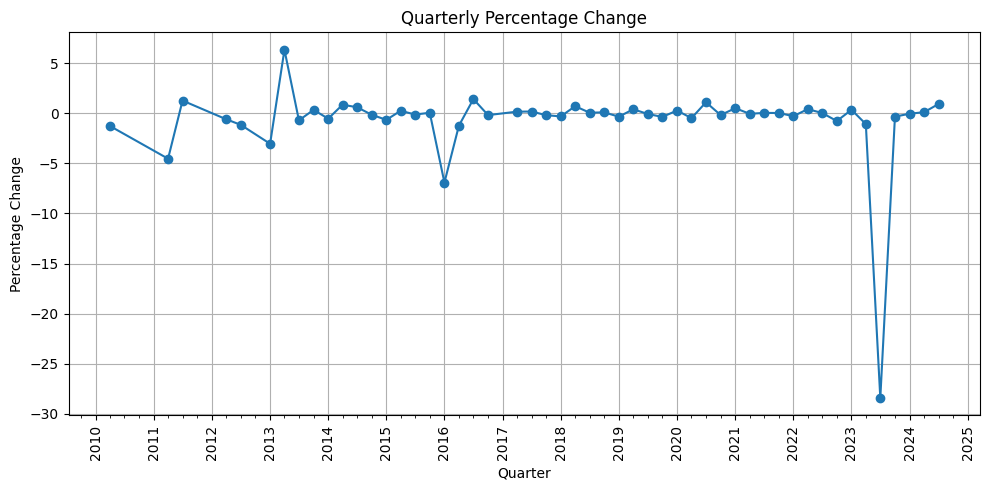

In [252]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='quarterly sentiments')

monthly_sentiments['Quarter'] = pd.to_datetime(monthly_sentiments['Quarter'])

plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiments['Quarter'], monthly_sentiments['Percentage Change'], marker='o')
plt.title('Quarterly Percentage Change')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1, 4, 7, 10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/t3/4f3r77m96393n7bqz6cbqc980000gn/T/ipykernel_34869/2541927223.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_sentiments['Quarter'] = pd.to_datetime(monthly_sentiments['Quarter'])


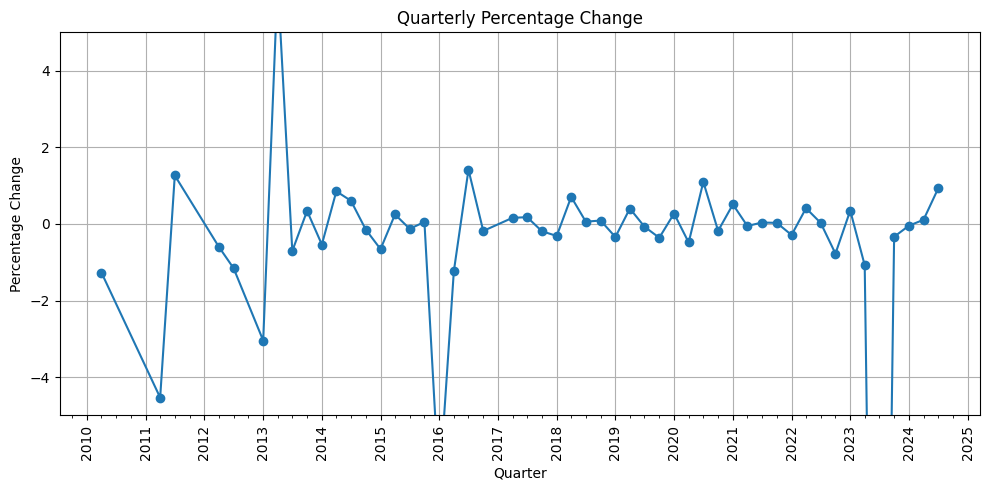

In [253]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='quarterly sentiments')

monthly_sentiments['Quarter'] = pd.to_datetime(monthly_sentiments['Quarter'])

plt.figure(figsize=(10, 5))
plt.plot(monthly_sentiments['Quarter'], monthly_sentiments['Percentage Change'], marker='o')
plt.title('Quarterly Percentage Change')
plt.xlabel('Quarter')
plt.ylabel('Percentage Change')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_minor_locator(mdates.MonthLocator([1, 4, 7, 10]))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.ylim(-5, 5)

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


### Year

In [257]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
df = pd.read_excel(file_path, sheet_name='master')

df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

df['Year'] = df['Date'].dt.to_period('Y')

grouped = df.groupby('Year').agg(
    Average_Sentiment=('Sentiments', 'mean'),
    Frequency=('Sentiments', 'count')
).reset_index()

with pd.ExcelWriter(file_path, mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    grouped.to_excel(writer, sheet_name='yearly sentiments', index=False)


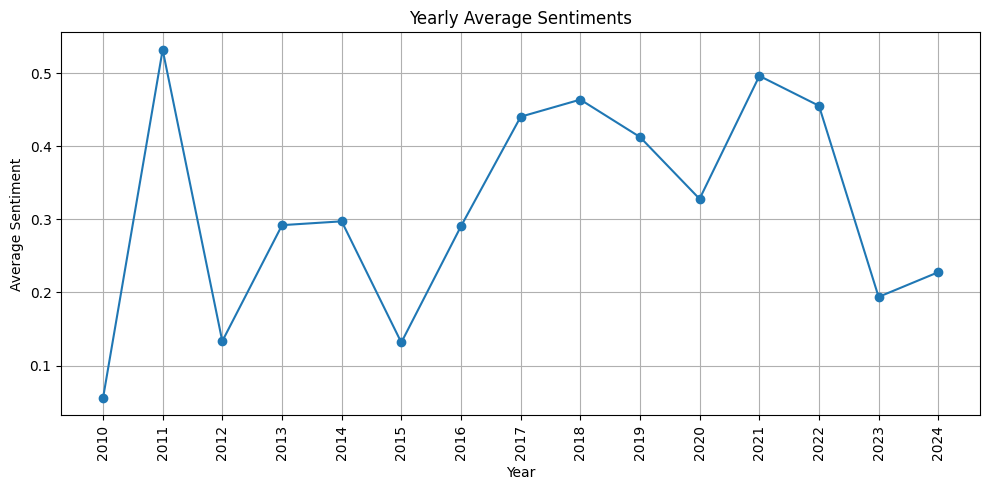

In [261]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
yearly_sentiments = pd.read_excel(file_path, sheet_name='yearly sentiments')

yearly_sentiments['Year'] = pd.to_datetime(yearly_sentiments['Year'], format='%Y')

plt.figure(figsize=(10, 5))
plt.plot(yearly_sentiments['Year'], yearly_sentiments['Average_Sentiment'], marker='o')
plt.title('Yearly Average Sentiments')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()


#### Year on Year

In [262]:
import pandas as pd

file_path = 'final_market_sentiments.xlsx'
monthly_sentiments = pd.read_excel(file_path, sheet_name='yearly sentiments')

monthly_sentiments['Percentage Change'] = monthly_sentiments['Average_Sentiment'].pct_change()

with pd.ExcelWriter('final_market_sentiments.xlsx', mode='a', engine='openpyxl', if_sheet_exists='replace') as writer:
    monthly_sentiments.to_excel(writer, sheet_name='yearly sentiments', index=False)

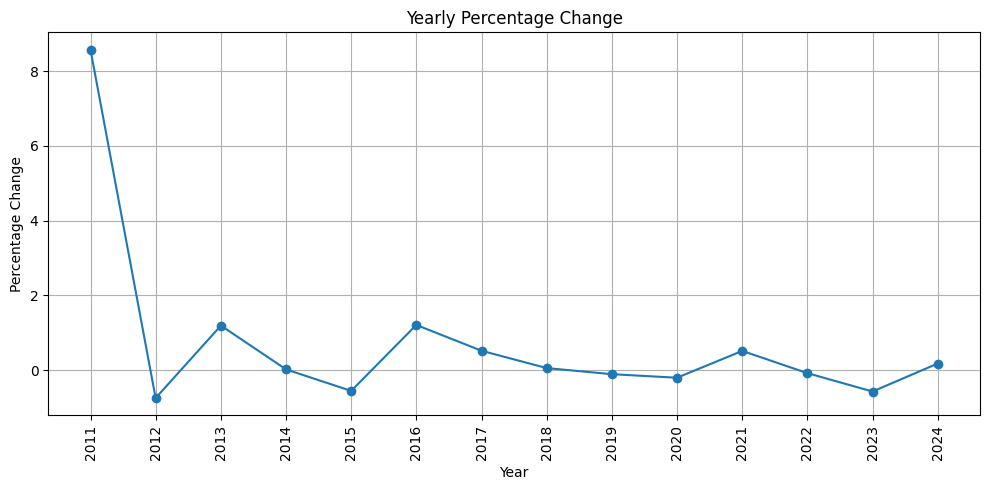

In [264]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

file_path = 'final_market_sentiments.xlsx'
yearly_sentiments = pd.read_excel(file_path, sheet_name='yearly sentiments')

yearly_sentiments['Year'] = pd.to_datetime(yearly_sentiments['Year'], format='%Y')

plt.figure(figsize=(10, 5))
plt.plot(yearly_sentiments['Year'], yearly_sentiments['Percentage Change'], marker='o')
plt.title('Yearly Percentage Change')
plt.xlabel('Year')
plt.ylabel('Percentage Change')

plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

